In [1]:
!pip install scikit-fuzzy
!pip install hdbscan
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -q -U segmentation-models-pytorch
!pip install -q --upgrade albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 11.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=15d09b0cb902a74f9bdf72946fb9fd216f5fc6142508add8c53c78c1a8755902
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.2 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which

In [2]:
import json
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as plt_path

from PIL import Image

from pathlib import Path
from pycocotools.coco import COCO

DATASET_PATH = Path('../input/synthetic-word-ocr')
img_root_path = DATASET_PATH / 'train/images'

In [3]:
import albumentations as albu
from albumentations import Compose, Normalize, Resize, Lambda
from albumentations.pytorch import ToTensorV2

In [4]:
from tqdm import tqdm

import skfuzzy as fuzz
import sklearn

from sklearn.model_selection import train_test_split

from skimage import img_as_ubyte, img_as_float, measure, data, segmentation, color, graph
from skimage.io import imread
from skimage.color import rgb2gray, label2rgb
from skimage.segmentation import morphological_chan_vese
from skimage.segmentation import quickshift as qs



from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from sklearn.cluster import DBSCAN, OPTICS, MeanShift, estimate_bandwidth
import hdbscan

In [5]:
import segmentation_models_pytorch as smp
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import torchvision.models as models

import segmentation_models_pytorch.utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
print(torch.__version__)
print(torchvision.__version__)
print(albu.__version__)

2.1.2
0.16.2
1.4.8


----

### Імпорт датасету

In [7]:
anno_path = DATASET_PATH / 'annotation-small.json'
with open(DATASET_PATH / 'annotation-small.json', 'r') as f:
    annot_data = json.load(f)

In [8]:
coco_anno = COCO(str(anno_path))
cat_ids = coco_anno.getCatIds()
cats = coco_anno.loadCats(cat_ids)
img_ids = coco_anno.getImgIds(catIds=cat_ids)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [9]:
len(img_ids)

8366

Вибір seed для налаштування генератора випадкових чисел:

In [10]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


In [11]:
seed=42  
seed_torch(seed)

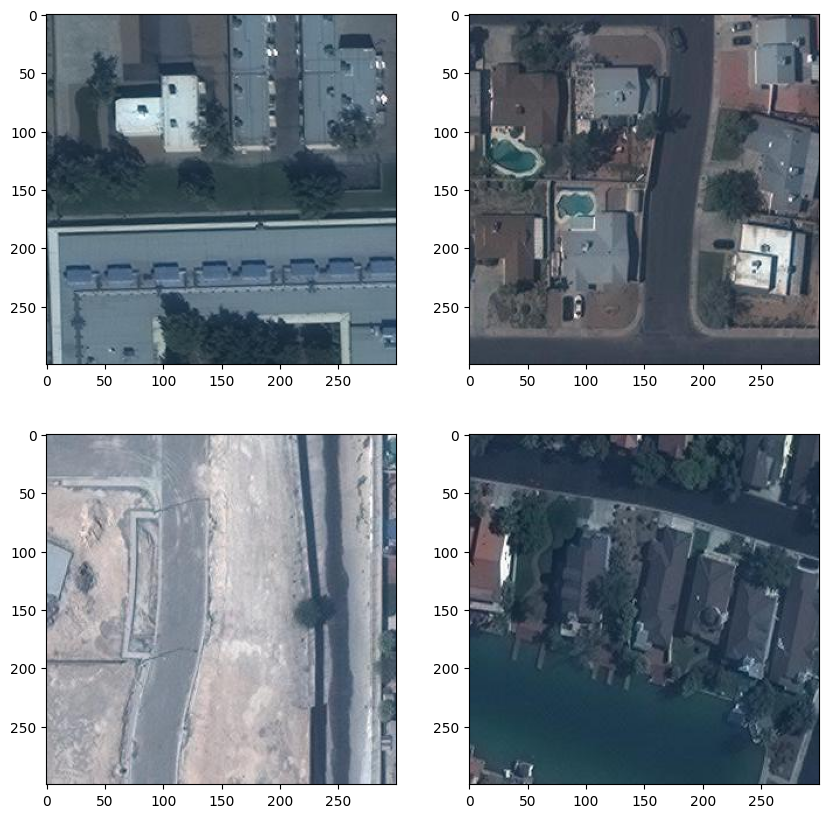

In [12]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(img_root_path, c_row['file_name']))
    c_ax.imshow(img_data)

In [13]:
image_df

,id,file_name,width,height
0,232566,000000232566.jpg,300,300
1,160847,000000160847.jpg,300,300
2,1457,000000001457.jpg,300,300
3,257667,000000257667.jpg,300,300
4,89311,000000089311.jpg,300,300
...,...,...,...,...
8361,190298,000000190298.jpg,300,300
8362,186493,000000186493.jpg,300,300
8363,86189,000000086189.jpg,300,300
8364,32455,000000032455.jpg,300,300


In [14]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
50911,267882,31411,"[[290.0, 279.0, 300.0, 280.0, 300.0, 300.0, 28...",216.0,"[279.0, 289.0, 21.0, 11.0]",100,0
69184,1815730,212995,"[[180.0, 89.0, 179.99999999999997, 8.0, 252.99...",9452.0,"[-2.842170943040401e-14, 179.99999999999997, 2...",100,0
62965,1771242,207753,"[[250.0, 300.0, 248.0, 298.0, 280.0, 244.0, 27...",2761.0,"[237.0, 248.0, 63.0, 52.0]",100,0


In [15]:
annot_df

,id,image_id,segmentation,area,bbox,category_id,iscrowd
0,585133,68701,"[[191.0, 95.0, 191.0, 28.999999999999996, 214....",2646.0,"[28.999999999999996, 191.0, 209.0, 47.0]",100,0
1,1792841,210291,"[[49.0, -6.184466335694134e-15, 58.0, 10.99999...",3055.0,"[-6.184466335694134e-15, 0.0, 74.0, 61.0]",100,0
2,608388,71375,"[[186.0, 36.0, 222.0, 37.00000000000001, 222.0...",2666.0,"[36.0, 186.0, 223.0, 73.0]",100,0
3,83413,9865,"[[214.0, 259.0, 198.0, 259.0, 198.0, 262.0, 14...",10192.0,"[82.00000000000001, 82.00000000000001, 180.0, ...",100,0
4,2082270,244243,"[[300.0, 267.0, 295.0, 267.0, 295.0, 241.0, 27...",1467.0,"[241.0, 279.0, 59.0, 21.0]",100,0
...,...,...,...,...,...,...,...
71866,410807,48225,"[[49.99999999999999, 65.0, 60.99999999999999, ...",451.0,"[49.99999999999999, 49.99999999999999, 15.0000...",100,0
71867,1223435,143578,"[[255.0, 118.0, 254.0, 114.0, 237.0, 116.0, 23...",6456.0,"[32.0, 216.0, 223.0, 84.0]",100,0
71868,32271,3847,"[[36.99999999999999, 66.0, 36.999999999999986,...",5786.0,"[0.0, 4.999999999999981, 94.99999999999999, 99.0]",100,0
71869,2014841,236326,"[[78, 101, 78, 142, 21, 142, 21, 146, 1, 146, ...",2937.0,"[1, 0, 145, 78]",100,0


In [16]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

8366 + 71871 -> 71871


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
60388,1923929,225678,"[[300, 6, 298, 6, 294, 11, 283, 12, 279, 6, 27...",208.0,"[6, 279, 294, 21]",100,0,225678,000000225678.jpg,300,300
65042,149548,17617,"[[300, 105, 290, 104, 300, 49, 300, 105]]",280.0,"[104, 290, 196, 10]",100,0,17617,000000017617.jpg,300,300


---

Поділ датасету на тренувальний, валідаційний та тестовий піднабори:

In [17]:
train_img_ids, valid_img_ids = train_test_split(img_ids, test_size=0.2, random_state=seed)
valid_img_ids, test_img_ids = train_test_split(valid_img_ids, test_size=0.5, random_state=seed)
print(len(train_img_ids), len(valid_img_ids), len(test_img_ids))

6692 837 837


In [18]:
test_df = full_df[full_df['image_id'].isin(test_img_ids)]

In [19]:
test_df

,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
14,1097580,128839,"[[0.0, 27.00000000000001, 8.0, 34.000000000000...",85.0,"[0.0, 0.0, 34.00000000000001, 8.0]",100,0,128839,000000128839.jpg,300,300
24,1959356,229834,"[[59.999999999999986, 52.0, 59.999999999999986...",3727.0,"[0.0, 52.999999999999986, 135.0, 82.0000000000...",100,0,229834,000000229834.jpg,300,300
42,945974,111105,"[[286.0, 51.99999999999997, 291.0, 51.99999999...",2917.0,"[51.99999999999997, 223.0, 240.00000000000003,...",100,0,111105,000000111105.jpg,300,300
45,793714,93098,"[[244, 291, 168, 291, 168, 269, 184, 268, 183,...",2255.0,"[168, 168, 123, 76]",100,0,93098,000000093098.jpg,300,300
76,55824,6582,"[[2.0, -9.062386313690414e-15, 3.0, 1.99999999...",3574.0,"[-9.062386313690414e-15, 0.0, 24.0000000000000...",100,0,6582,000000006582.jpg,300,300
...,...,...,...,...,...,...,...,...,...,...,...
71854,1157353,135852,"[[232.0, 212.0, 246.0, 211.0, 245.0, 177.0, 26...",2800.0,"[175.0, 229.0, 114.0, 60.0]",100,0,135852,000000135852.jpg,300,300
71857,533060,62516,"[[0, 70, 2, 70, 3, 114, 0, 114, 0, 70]]",110.0,"[0, 0, 70, 3]",100,0,62516,000000062516.jpg,300,300
71866,410807,48225,"[[49.99999999999999, 65.0, 60.99999999999999, ...",451.0,"[49.99999999999999, 49.99999999999999, 15.0000...",100,0,48225,000000048225.jpg,300,300
71867,1223435,143578,"[[255.0, 118.0, 254.0, 114.0, 237.0, 116.0, 23...",6456.0,"[32.0, 216.0, 223.0, 84.0]",100,0,143578,000000143578.jpg,300,300


---

### Реалізація допоміжних функцій

In [20]:
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), range(in_img.shape[1]), indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = plt_path.Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

#### Отримання сегментаційних масок

In [21]:
def create_cluster_masks(labels_array, num_clusters=3):
    masks = []
    for cluster_id in range(num_clusters):
        mask = (labels_array == cluster_id).astype(int)
        masks.append(mask)
    return masks

#### Функції оцінки якості роботи алгоритмів

Для перевірки якості роботи кожного методу я обрала наступні метрики: точність (accuracy), IoU та dice_loss.

In [22]:
def accuracy(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.astype(bool)
    pred_mask = pred_mask.astype(bool)
    TP = np.sum(np.logical_and(pred_mask, groundtruth_mask))
    TN = np.sum(np.logical_and(~pred_mask, ~groundtruth_mask))
    FP = np.sum(np.logical_and(pred_mask, ~groundtruth_mask))
    FN = np.sum(np.logical_and(~pred_mask, groundtruth_mask))
    total_pixels = groundtruth_mask.size
    acc = (TP + TN) / total_pixels
    return round(acc, 5)
    

In [23]:
def dice_loss(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(1-dice, 5) 

In [24]:
def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 5)

---

## Алгоритми кластеризації

### K-Means

In [ ]:
def k_means(input_image, number_of_clusters):
    converted_image = img_as_ubyte(input_image)
    converted_image = cv2.cvtColor(converted_image, cv2.COLOR_BGR2RGB)
    pixel_matrix = np.float32(converted_image.reshape((-1, 3)))
    termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
    ret, assigned_labels, cluster_centers = cv2.kmeans(pixel_matrix, number_of_clusters, None, termination_criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    cluster_centers = np.uint8(cluster_centers)
    assigned_labels = assigned_labels.flatten()
    colored_image = cluster_centers[assigned_labels]
    final_image = colored_image.reshape(input_image.shape)
    label_matrix = assigned_labels.reshape((input_image.shape[0], input_image.shape[1]))
    return final_image, label_matrix

Завдання полягає в тому, щоб розпізнати, які пікселі зображень належать до будинків, а які ні (**однокласова сегментація**). Оскільки алгоритм k-середніх дуже погано працює з кількістю кластерів = 2 для **багатокласових (багатоколірних) зображень**, а при більшій кількості кластерів ми отримаємо багато різних кластерів, деякі з яких можуть позначати будинки (тому пошук правильної комбінації стане набагато складнішим), ми будемо працювати з **num_clusters=3** і використовувати наступний алгоритм отримання оціночних балів (середній IoU, середній Dice_loss і середня accuracy):

1. Кластеризуємо зображення за допомогою алгоритму k-середніх.
2. Перетворіть матрицю k_means_labels у 3 бінарні маски, що відповідають кожному окремому кластеру.
3. Обчислити IoU для кожної передбаченої маски та **вибрати лише маску з найвищим показником IoU**.

(Додаткові експерименти показали, що найкращі показники IoU та втрати Dice отримані для одних і тих самих масок. Відмінності були помічені лише з точністю, але цю метрику не можна вважати високонадійною для оцінки, оскільки якщо на зображенні є дуже дрібні об'єкти, то метод, який їх не розрізняє, матиме високу піксельну точність).


Спочатку продемонструємо наочно роботу методу на 10 зображеннях:

In [ ]:
num_images=10  
num_clusters=3

In [ ]:
fig, m_axs = plt.subplots(num_images, num_clusters+3, figsize = ((num_clusters+3)*5, num_images*5))
for (m_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    i_ax = m_ax[0]  # Image axis
    cl_ax = m_ax[1] # Clusterized image axis
    gt_ax = m_ax[2] # Ground truth axis
    mask_axes = m_ax[3:num_clusters+3] # Mask axes
    
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cl_ax.imshow(k_means_img)
    cl_ax.set_title(f"Clustered image")
    cl_ax.axis('off')
    
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)
    # rgba_img = np.concatenate([img_data, np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)], -1)
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')

    curr_id=0
    best_iou=0
    best_iou_id=0
    best_dice_loss=1
    best_dice_loss_id=0
    best_acc=0
    best_acc_id=0
    
    
    for mask_ax, mask in zip(mask_axes, cluster_masks):
        mask_ax.imshow(mask)
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)
        mask_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
        mask_ax.axis('off')

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_iou_id = curr_id
        if curr_dice_loss < best_dice_loss:
            best_dice_loss = curr_dice_loss
            best_dice_loss_id = curr_id
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_acc_id = curr_id       

        curr_id+=1

    

Тепер кластеризуємо всі тестові зображення, вибираємо найкращі маски відповідно до оцінок IoU та оцінюємо всі метрики:

In [ ]:
metrics=[[0,0,0]]

In [ ]:
for image_id in tqdm(test_img_ids, desc="Processing images"):
    c_df = test_df[test_df['image_id'] == image_id]
    img_name = c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {image_id}, img_name: {img_name}")
    
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)

    best_iou = 0
    best_dice_loss = 1
    chosen_acc = 0
    
    for mask in cluster_masks:
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_dice_loss = curr_dice_loss
            chosen_acc = curr_acc

        curr_id += 1
    #print(f"    best_iou: {best_iou}, best_dice_loss: {best_dice_loss}, chosen_acc: {chosen_acc}")
    metrics.append([best_iou, best_dice_loss, chosen_acc])


In [ ]:
metrics.pop(0)

In [ ]:
metrics[:5]

In [ ]:
iou_column = [row[0] for row in metrics]
dice_loss_column = [row[1] for row in metrics]
acc_column = [row[2] for row in metrics]

mean_iou = sum(iou_column) / len(iou_column)
mean_dice_loss = sum(dice_loss_column) / len(dice_loss_column)
mean_acc = sum(acc_column) / len(acc_column)

k_means_metrics = [mean_iou, mean_dice_loss, mean_acc]

print(f"mean_iou: {k_means_metrics[0]:.4f}, mean_dice_loss: {k_means_metrics[1]:.4f}, mean_acc: {k_means_metrics[2]:.4f}")

---

In [ ]:
num_clusters=2

In [ ]:
fig, m_axs = plt.subplots(num_images, num_clusters+3, figsize = ((num_clusters+3)*5, num_images*5))
for (m_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    i_ax = m_ax[0]  # Image axis
    cl_ax = m_ax[1] # Clusterized image axis
    gt_ax = m_ax[2] # Ground truth axis
    mask_axes = m_ax[3:num_clusters+3] # Mask axes
    
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cl_ax.imshow(k_means_img)
    cl_ax.set_title(f"Clustered image")
    cl_ax.axis('off')
    
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)
    # rgba_img = np.concatenate([img_data, np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)], -1)
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')

    curr_id=0
    best_iou=0
    best_iou_id=0
    best_dice_loss=1
    best_dice_loss_id=0
    best_acc=0
    best_acc_id=0
    
    
    for mask_ax, mask in zip(mask_axes, cluster_masks):
        mask_ax.imshow(mask)
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)
        mask_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
        mask_ax.axis('off')

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_iou_id = curr_id
        if curr_dice_loss < best_dice_loss:
            best_dice_loss = curr_dice_loss
            best_dice_loss_id = curr_id
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_acc_id = curr_id       

        curr_id+=1

    

In [ ]:
metrics=[[0,0,0]]

In [ ]:
for image_id in tqdm(test_img_ids, desc="Processing images"):
    c_df = test_df[test_df['image_id'] == image_id]
    img_name = c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {image_id}, img_name: {img_name}")
    
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)

    best_iou = 0
    best_dice_loss = 1
    chosen_acc = 0
    
    for mask in cluster_masks:
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_dice_loss = curr_dice_loss
            chosen_acc = curr_acc

        curr_id += 1
    #print(f"    best_iou: {best_iou}, best_dice_loss: {best_dice_loss}, chosen_acc: {chosen_acc}")
    metrics.append([best_iou, best_dice_loss, chosen_acc])


In [ ]:
metrics.pop(0)

In [ ]:
metrics[:5]

In [ ]:
iou_column = [row[0] for row in metrics]
dice_loss_column = [row[1] for row in metrics]
acc_column = [row[2] for row in metrics]

mean_iou = sum(iou_column) / len(iou_column)
mean_dice_loss = sum(dice_loss_column) / len(dice_loss_column)
mean_acc = sum(acc_column) / len(acc_column)

k_means_metrics = [mean_iou, mean_dice_loss, mean_acc]

print(f"mean_iou: {k_means_metrics[0]:.4f}, mean_dice_loss: {k_means_metrics[1]:.4f}, mean_acc: {k_means_metrics[2]:.4f}")

---

In [ ]:
num_clusters=4

In [ ]:
fig, m_axs = plt.subplots(num_images, num_clusters+3, figsize = ((num_clusters+3)*5, num_images*5))
for (m_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    i_ax = m_ax[0]  # Image axis
    cl_ax = m_ax[1] # Clusterized image axis
    gt_ax = m_ax[2] # Ground truth axis
    mask_axes = m_ax[3:num_clusters+3] # Mask axes
    
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cl_ax.imshow(k_means_img)
    cl_ax.set_title(f"Clustered image")
    cl_ax.axis('off')
    
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)
    # rgba_img = np.concatenate([img_data, np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)], -1)
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')

    curr_id=0
    best_iou=0
    best_iou_id=0
    best_dice_loss=1
    best_dice_loss_id=0
    best_acc=0
    best_acc_id=0
    
    
    for mask_ax, mask in zip(mask_axes, cluster_masks):
        mask_ax.imshow(mask)
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)
        mask_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
        mask_ax.axis('off')

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_iou_id = curr_id
        if curr_dice_loss < best_dice_loss:
            best_dice_loss = curr_dice_loss
            best_dice_loss_id = curr_id
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_acc_id = curr_id       

        curr_id+=1

    

In [ ]:
metrics=[[0,0,0]]

In [ ]:
for image_id in tqdm(test_img_ids, desc="Processing images"):
    c_df = test_df[test_df['image_id'] == image_id]
    img_name = c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {image_id}, img_name: {img_name}")
    
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)

    best_iou = 0
    best_dice_loss = 1
    chosen_acc = 0
    
    for mask in cluster_masks:
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_dice_loss = curr_dice_loss
            chosen_acc = curr_acc

        curr_id += 1
    #print(f"    best_iou: {best_iou}, best_dice_loss: {best_dice_loss}, chosen_acc: {chosen_acc}")
    metrics.append([best_iou, best_dice_loss, chosen_acc])


In [ ]:
metrics.pop(0)

In [ ]:
metrics[:5]

In [ ]:
iou_column = [row[0] for row in metrics]
dice_loss_column = [row[1] for row in metrics]
acc_column = [row[2] for row in metrics]

mean_iou = sum(iou_column) / len(iou_column)
mean_dice_loss = sum(dice_loss_column) / len(dice_loss_column)
mean_acc = sum(acc_column) / len(acc_column)

k_means_metrics = [mean_iou, mean_dice_loss, mean_acc]

print(f"mean_iou: {k_means_metrics[0]:.4f}, mean_dice_loss: {k_means_metrics[1]:.4f}, mean_acc: {k_means_metrics[2]:.4f}")

---

In [ ]:
num_clusters=5

In [ ]:
fig, m_axs = plt.subplots(num_images, num_clusters+3, figsize = ((num_clusters+3)*5, num_images*5))
for (m_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    i_ax = m_ax[0]  # Image axis
    cl_ax = m_ax[1] # Clusterized image axis
    gt_ax = m_ax[2] # Ground truth axis
    mask_axes = m_ax[3:num_clusters+3] # Mask axes
    
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cl_ax.imshow(k_means_img)
    cl_ax.set_title(f"Clustered image")
    cl_ax.axis('off')
    
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)
    # rgba_img = np.concatenate([img_data, np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)], -1)
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')

    curr_id=0
    best_iou=0
    best_iou_id=0
    best_dice_loss=1
    best_dice_loss_id=0
    best_acc=0
    best_acc_id=0
    
    
    for mask_ax, mask in zip(mask_axes, cluster_masks):
        mask_ax.imshow(mask)
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)
        mask_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
        mask_ax.axis('off')

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_iou_id = curr_id
        if curr_dice_loss < best_dice_loss:
            best_dice_loss = curr_dice_loss
            best_dice_loss_id = curr_id
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_acc_id = curr_id       

        curr_id+=1

    

In [ ]:
metrics=[[0,0,0]]

---

### Fuzzy C-Means

In [ ]:
num_images=10  
num_clusters=3

In [ ]:
def fuzzy_c_means(image, num_clusters=3, fuzziness=2):
    #image = img_as_float(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape((-1, 3))

    cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(pixels.T, c=num_clusters, m=fuzziness, error=0.005, maxiter=1000, init=None)
    cluster_membership = np.argmax(u_orig, axis=0)
    result_img = np.zeros_like(pixels)
    for i, pix in enumerate(u_orig.T):
        result_img[i] = cntr[np.argmax(pix)]

    fuzzy_image = result_img.reshape(image.shape).astype(np.uint8)

    cluster_membership = np.argmax(u_orig, axis=0).reshape(image.shape[:2])
    
    return fuzzy_image, cluster_membership

In [ ]:
fig, m_axs = plt.subplots(num_images, num_clusters+3, figsize = ((num_clusters+3)*5, num_images*5))
for (m_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    i_ax = m_ax[0]  # Image axis
    cl_ax = m_ax[1] # Clusterized image axis
    gt_ax = m_ax[2] # Ground truth axis
    mask_axes = m_ax[3:num_clusters+3] # Mask axes
    
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    fuzzy_img, fuzzy_labels = fuzzy_c_means(img_data, num_clusters)
    cl_ax.imshow(fuzzy_img)
    cl_ax.set_title(f"Clustered image")
    cl_ax.axis('off')
    
    cluster_masks = create_cluster_masks(fuzzy_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')

    curr_id=0
    best_iou=0
    best_iou_id=0
    best_dice_loss=1
    best_dice_loss_id=0
    best_acc=0
    best_acc_id=0
    
    
    for mask_ax, mask in zip(mask_axes, cluster_masks):
        mask_ax.imshow(mask)
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)
        mask_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
        mask_ax.axis('off')

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_iou_id = curr_id
        if curr_dice_loss < best_dice_loss:
            best_dice_loss = curr_dice_loss
            best_dice_loss_id = curr_id
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_acc_id = curr_id       

        curr_id+=1
    

In [ ]:
metrics=[[0,0,0]]

In [ ]:
for image_id in tqdm(test_img_ids, desc="Processing images"):
    c_df = test_df[test_df['image_id'] == image_id]
    img_name = c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {image_id}, img_name: {img_name}")
    
    fuzzy_img, fuzzy_labels = fuzzy_c_means(img_data, num_clusters)
    cluster_masks = create_cluster_masks(fuzzy_labels, num_clusters=num_clusters)
    gt_mask = rows_to_segmentation(img_data, c_df)

    best_iou = 0
    best_dice_loss = 1
    chosen_acc = 0
    
    for mask in cluster_masks:
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)

        if curr_iou > best_iou:
            best_iou = curr_iou
            best_dice_loss = curr_dice_loss
            chosen_acc = curr_acc

        curr_id += 1
    #print(f"    best_iou: {best_iou}, best_dice_loss: {best_dice_loss}, chosen_acc: {chosen_acc}")
    metrics.append([best_iou, best_dice_loss, chosen_acc])


In [ ]:
metrics.pop(0)

In [ ]:
metrics[:5]

In [ ]:
iou_column = [row[0] for row in metrics]
dice_loss_column = [row[1] for row in metrics]
acc_column = [row[2] for row in metrics]

mean_iou = sum(iou_column) / len(iou_column)
mean_dice_loss = sum(dice_loss_column) / len(dice_loss_column)
mean_acc = sum(acc_column) / len(acc_column)

fuzzy_c_means_metrics = [mean_iou, mean_dice_loss, mean_acc]

print(f"mean_iou: {fuzzy_c_means_metrics[0]:.4f}, mean_dice_loss: {fuzzy_c_means_metrics[1]:.4f}, mean_acc: {fuzzy_c_means_metrics[2]:.4f}")

---

### Morphological Snakes (MorphACWE)

In [ ]:
def morph_acwe(input_image):
    image = img_as_float(rgb2gray(input_image))
    mask = morphological_chan_vese(image, num_iter=35, init_level_set='checkerboard', lambda1=1, lambda2=1)
    return mask

In [ ]:
metrics=[[0,0,0]]

In [ ]:
fig, m_axs = plt.subplots(num_images, 3, figsize = (15, num_images*5))
for (i_ax, gt_ax, cl_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    gt_mask = rows_to_segmentation(img_data, c_df) 
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')
    
    #алгоритм часто обирає області, прямо протилежні до шуканих,
    #тому ми досліджуватимемо по 2 маски зображення - отриману методом та протилежну їй,
    #порівнюємо ці маски за IoT та обираємо найкращу, з якою і працюватимемо
    morph_acwe_mask = morph_acwe(img_data)
    morph_acwe_mask = morph_acwe_mask.astype(bool)
    #print(morph_acwe_mask)
    neg_morph_acwe_mask = np.invert(morph_acwe_mask)
    #print(neg_morph_acwe_mask)
    acwe_iou = iou(gt_mask, morph_acwe_mask)
    neg_acwe_iou = iou(gt_mask, neg_morph_acwe_mask)
    if neg_acwe_iou > acwe_iou:
        acwe_img = neg_morph_acwe_mask
        curr_iou = neg_acwe_iou
    else:
        acwe_img = morph_acwe_mask
        curr_iou = acwe_iou
    
    
    cl_ax.imshow(acwe_img)
    #curr_iou = iou(gt_mask, acwe_img)
    curr_dice_loss = dice_loss(gt_mask, acwe_img)
    curr_acc = accuracy(gt_mask, acwe_img)
    cl_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
    cl_ax.axis('off')

    metrics.append([curr_iou, curr_dice_loss, curr_acc])
    

In [ ]:
metrics

In [ ]:
metrics=[[0,0,0]]

In [ ]:
for image_id in tqdm(test_img_ids, desc="Processing images"):
    c_df = test_df[test_df['image_id'] == image_id]
    img_name = c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {image_id}, img_name: {img_name}")

    gt_mask = rows_to_segmentation(img_data, c_df)

    morph_acwe_mask = morph_acwe(img_data)
    morph_acwe_mask = morph_acwe_mask.astype(bool)
    neg_morph_acwe_mask = np.invert(morph_acwe_mask)
    acwe_iou = iou(gt_mask, morph_acwe_mask)
    neg_acwe_iou = iou(gt_mask, neg_morph_acwe_mask)
    if neg_acwe_iou > acwe_iou:
        acwe_img = neg_morph_acwe_mask
        curr_iou = neg_acwe_iou
    else:
        acwe_img = morph_acwe_mask
        curr_iou = acwe_iou
    
    curr_dice_loss = dice_loss(gt_mask, acwe_img)
    curr_acc = accuracy(gt_mask, acwe_img)
    
    #print(f"    curr_iou: {curr_iou}, curr_dice_loss: {curr_dice_loss}, curr_acc: {curr_acc}")
    metrics.append([curr_iou, curr_dice_loss, curr_acc])


In [ ]:
metrics.pop(0)

In [ ]:
metrics[:5]

In [ ]:
iou_column = [row[0] for row in metrics]
dice_loss_column = [row[1] for row in metrics]
acc_column = [row[2] for row in metrics]

mean_iou = sum(iou_column) / len(iou_column)
mean_dice_loss = sum(dice_loss_column) / len(dice_loss_column)
mean_acc = sum(acc_column) / len(acc_column)

acwe_metrics = [mean_iou, mean_dice_loss, mean_acc]

print(f"mean_iou: {acwe_metrics[0]:.4f}, mean_dice_loss: {acwe_metrics[1]:.4f}, mean_acc: {acwe_metrics[2]:.4f}")

---

Для порівняння - робота алгоритму до введення "негативної" маски

In [ ]:
metrics=[[0,0,0]]

In [ ]:
fig, m_axs = plt.subplots(num_images, 3, figsize = (15, num_images*5))
for (i_ax, gt_ax, cl_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    gt_mask = rows_to_segmentation(img_data, c_df)
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')
    
    acwe_img = morph_acwe(img_data)    
    cl_ax.imshow(acwe_img)
    curr_iou = iou(gt_mask, acwe_img)
    curr_dice_loss = dice_loss(gt_mask, acwe_img)
    curr_acc = accuracy(gt_mask, acwe_img)
    cl_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
    cl_ax.axis('off')

    metrics.append([curr_iou, curr_dice_loss, curr_acc])
    

In [ ]:
for image_id in tqdm(test_img_ids, desc="Processing images"):
    c_df = test_df[test_df['image_id'] == image_id]
    img_name = c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {image_id}, img_name: {img_name}")

    gt_mask = rows_to_segmentation(img_data, c_df)

    acwe_img = morph_acwe(img_data)
    curr_iou = iou(gt_mask, acwe_img)
    curr_dice_loss = dice_loss(gt_mask, acwe_img)
    curr_acc = accuracy(gt_mask, acwe_img)
    
    #print(f"    curr_iou: {curr_iou}, curr_dice_loss: {curr_dice_loss}, curr_acc: {curr_acc}")
    metrics.append([curr_iou, curr_dice_loss, curr_acc])


In [ ]:
metrics.pop(0)

In [ ]:
metrics[:5]

In [ ]:
iou_column = [row[0] for row in metrics]
dice_loss_column = [row[1] for row in metrics]
acc_column = [row[2] for row in metrics]

mean_iou = sum(iou_column) / len(iou_column)
mean_dice_loss = sum(dice_loss_column) / len(dice_loss_column)
mean_acc = sum(acc_column) / len(acc_column)

acwe_metrics = [mean_iou, mean_dice_loss, mean_acc]

print(f"mean_iou: {acwe_metrics[0]:.4f}, mean_dice_loss: {acwe_metrics[1]:.4f}, mean_acc: {acwe_metrics[2]:.4f}")

Очевидно, що з уведенням порівняння отриманої та "негативної" до неї масок якість сегментації алгоритмом MorphACWE відчутно покращилася.

---

In [ ]:
metrics=[[0,0,0]]

In [ ]:
def morph_acwe_2(input_image):
    image = img_as_float(input_image)
    mask = morphological_chan_vese(image, num_iter=35, init_level_set='checkerboard', lambda1=1, lambda2=1)
    return mask

In [ ]:
num_images=10

In [ ]:
fig, m_axs = plt.subplots(num_images, 4, figsize = (20, num_images*5))
for (i_ax, db_ax, gt_ax, cl_ax), (c_id, c_df) in zip(m_axs, test_df.groupby('image_id')):
    img_name=c_df['file_name'].values[0]
    img_data = imread(os.path.join(img_root_path, img_name))
    #print(f"image_id: {c_id}, img_name: {img_name}")
    
    i_ax.imshow(img_data)
    i_ax.set_title(f"Original image")
    i_ax.axis('off')
    
    # Обрахунок нормалізованої різниці зеленого та червоного каналів
    norm_img_data = img_data / 255.0
    M, N = norm_img_data.shape[:2]
    f = (norm_img_data[:,:,1] - norm_img_data[:,:,0]) / (norm_img_data[:,:,1] + norm_img_data[:,:,0] + 1e-6)  # малий знаменник для уникнення ділення на нуль
    ngrd = 0.5 * (f + 1)  # Нормалізація f до діапазону [0,1]
    
    #DBSCAN
    matrix = np.column_stack((norm_img_data[:,:,2].flatten(), ngrd.flatten()))
    dbscan = DBSCAN(eps=0.0122, min_samples=500)
    labels = dbscan.fit_predict(matrix)
    dbscan_output = np.reshape(labels + 1, (M, N)) / 2
    
    # Морфологічні операції для покращення результату сегментації
    #img_dilate = cv2.dilate(L, np.ones((3,3), np.uint8))
    #img_erosion = cv2.erode(img_dilate, np.ones((5,5), np.uint8))
    
    db_ax.imshow(dbscan_output,cmap='rainbow_r')
    db_ax.set_title(f"DBSCAN image")
    db_ax.axis('off')
    
    gt_mask = rows_to_segmentation(img_data, c_df) 
    gt_ax.imshow(gt_mask)
    gt_ax.set_title(f"Groundtruth mask")
    gt_ax.axis('off')
    
    #алгоритм часто обирає області, прямо протилежні до шуканих,
    #тому ми досліджуватимемо по 2 маски зображення - отриману методом та протилежну їй,
    #порівнюємо ці маски за IoT та обираємо найкращу, з якою і працюватимемо
    morph_acwe_mask = morph_acwe_2(dbscan_output)
    morph_acwe_mask = morph_acwe_mask.astype(bool)
    #print(morph_acwe_mask)
    neg_morph_acwe_mask = np.invert(morph_acwe_mask)
    #print(neg_morph_acwe_mask)
    acwe_iou = iou(gt_mask, morph_acwe_mask)
    neg_acwe_iou = iou(gt_mask, neg_morph_acwe_mask)
    if neg_acwe_iou > acwe_iou:
        acwe_img = neg_morph_acwe_mask
        curr_iou = neg_acwe_iou
    else:
        acwe_img = morph_acwe_mask
        curr_iou = acwe_iou
    
    
    cl_ax.imshow(acwe_img)
    #curr_iou = iou(gt_mask, acwe_img)
    curr_dice_loss = dice_loss(gt_mask, acwe_img)
    curr_acc = accuracy(gt_mask, acwe_img)
    cl_ax.set_title(f"IoU: {curr_iou:.4f}; dice_loss: {curr_dice_loss:.4f}; acc: {curr_acc:.4f};")
    cl_ax.axis('off')

    metrics.append([curr_iou, curr_dice_loss, curr_acc])
    

----

Допоміжні функції

In [25]:
def get_mask(coco, img_id, cat_ids):
    img_inf = coco.loadImgs(img_id)[0]
    img_shape = (img_inf['width'], img_inf['height'], len(cat_ids))
    ann_ids = coco_anno.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    masks = np.zeros(img_shape)
    for idx, cat_id in enumerate(cat_ids):
        mask = np.zeros(img_shape[:2])
        for ann in anns:
            if cat_id == ann['category_id']:
                mask = np.maximum(mask, coco_anno.annToMask(ann))
        masks[:, :, idx] = mask
    return masks

In [31]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.transpose(1, 2, 0) 
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

In [32]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

----

In [33]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_basic_preprocessing(preprocessing_fn):
    return albu.Compose([
        albu.Resize(320, 320),
        albu.Lambda(image=preprocessing_fn),  #нормалізація
        albu.Lambda(image=to_tensor, mask=to_tensor)  #перетворення на тензор
    ])

In [34]:
class SegDataset(Dataset):
    def __init__(self, root_dir, img_ids, cat_ids, coco_api, preprocessing=None):
        self.root_dir = root_dir
        self.img_ids = img_ids
        self.cat_ids = cat_ids
        self.coco_api = coco_api
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco_api.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        file_path = self.root_dir / file_name
        img = Image.open(file_path).convert('RGB')
        img = np.array(img) 

        mask = get_mask(self.coco_api, img_id, self.cat_ids)
        
        if self.preprocessing:
            processed = self.preprocessing(image=img, mask=mask)
            img, mask = processed['image'], processed['mask']

        return img, mask
    
    def __len__(self):
        return len(self.img_ids)

### U-Net++ (temporary)

In [75]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    949 MiB |  11771 MiB | 633185 GiB | 633184 GiB |
|       from large pool |    842 MiB |  11683 MiB | 632521 GiB | 632520 GiB |
|       from small pool |    106 MiB |    128 MiB |    664 GiB |    664 GiB |
|---------------------------------------------------------------------------|
| Active memory         |    949 MiB |  11771 MiB | 633185 GiB | 633184 GiB |
|       from large pool |    842 MiB |  11683 MiB | 632521 GiB |

In [76]:
import torch
import gc

del model_c_unet_plus_plus, train_dataset, valid_dataset, test_dataset
gc.collect()
torch.cuda.empty_cache()

In [77]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    949 MiB |  11771 MiB | 633185 GiB | 633184 GiB |
|       from large pool |    842 MiB |  11683 MiB | 632521 GiB | 632520 GiB |
|       from small pool |    106 MiB |    128 MiB |    664 GiB |    664 GiB |
|---------------------------------------------------------------------------|
| Active memory         |    949 MiB |  11771 MiB | 633185 GiB | 633184 GiB |
|       from large pool |    842 MiB |  11683 MiB | 632521 GiB |

#### Використання segmentation-models-pytorch (U-мережа з енкодером reset, попередньо навчена на imagenet)

Функція smp.encoders.get_preprocessing_fn нормалізує дані зображення шляхом віднімання специфічного для ImageNet середнього значення і ділення на стандартне відхилення для кожного колірного каналу:

- Середнє значення для ImageNet (приблизне): [0.485, 0.456, 0.406]
- Стандартне відхилення для ImageNet (приблизне): [0.229, 0.224, 0.225]

А функція basic_preprocessing змінить розмір зображень і застосує цю нормалізацію

In [78]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation

# create segmentation model with pretrained encoder
model_unetpp = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [79]:
basic_preprocessing = get_basic_preprocessing(preprocessing_fn)

train_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

valid_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=valid_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

Подивимося, як виглядатимуть зображення, які будуть передані моделі (вони вже нормалізовані):

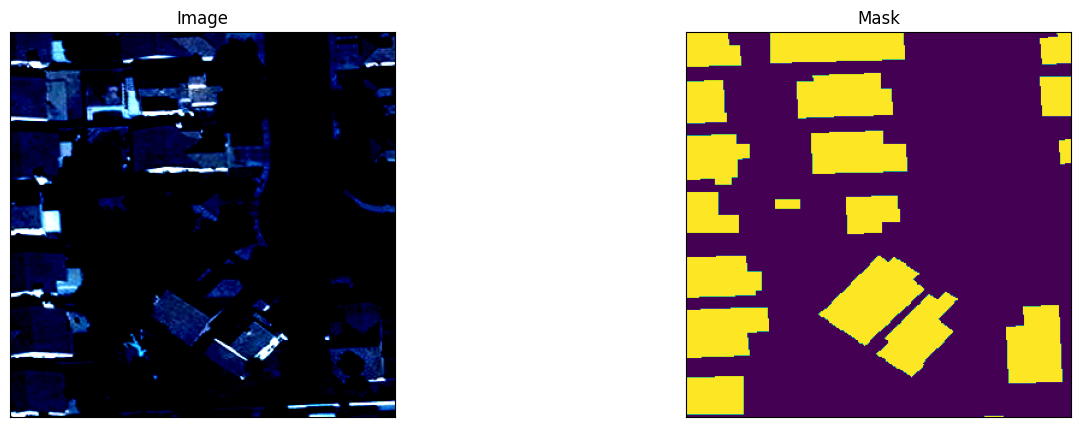

In [80]:
image, mask = train_dataset[0]
visualize(image=image.transpose(1, 2, 0), mask=mask.squeeze())

In [81]:
EPOCHS = 10
BATCH_SIZE = 16

In [82]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)

https://smp.readthedocs.io/en/latest/metrics.html - need to add accuracy as a metrics

In [83]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),smp.utils.metrics.Accuracy(threshold=0.5),]
optimizer = torch.optim.Adam([dict(params=model_unetpp.parameters(), lr=0.0001),])

In [84]:
train_epoch = smp.utils.train.TrainEpoch(
    model_unetpp, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model_unetpp, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [85]:
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_iou_score = []
train_accuracy = []
valid_dice_loss = []
valid_iou_score = []
valid_accuracy = []

for i in range(EPOCHS):

    print(f'\nEpoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    train_accuracy.append(train_logs['accuracy'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    valid_accuracy.append(valid_logs['accuracy'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        if i<10:
            torch.save(model_unetpp, './best_model_UnetPlusPlus_resnet50.pth')
        else:
            torch.save(model_unetpp, './best_model_over10_UnetPlusPlus_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 52/52 [00:12<00:00,  4.04it/s, dice_loss - 0.1672, iou_score - 0.7834, accuracy - 0.9424]
Model saved!

Epoch: 2
valid: 100%|██████████| 52/52 [00:12<00:00,  4.03it/s, dice_loss - 0.1224, iou_score - 0.8044, accuracy - 0.9496]
Model saved!

Epoch: 3
valid: 100%|██████████| 52/52 [00:12<00:00,  4.04it/s, dice_loss - 0.1113, iou_score - 0.8117, accuracy - 0.9521]
Model saved!

Epoch: 4
valid: 100%|██████████| 52/52 [00:12<00:00,  4.03it/s, dice_loss - 0.1022, iou_score - 0.8217, accuracy - 0.9554] 
Model saved!

Epoch: 5
valid: 100%|██████████| 52/52 [00:12<00:00,  4.02it/s, dice_loss - 0.1121, iou_score - 0.8044, accuracy - 0.9513]

Epoch: 6
valid: 100%|██████████| 52/52 [00:12<00:00,  4.03it/s, dice_loss - 0.1015, iou_score - 0.8193, accuracy - 0.9539] 

Epoch: 7
valid: 100%|██████████| 52/52 [00:12<00:00,  4.04it/s, dice_loss - 0.09467, iou_score - 0.8297, accuracy - 0.9576]
Model saved!

Epoch: 8
valid: 100%|██████████| 52/52 [00:12<00:00,  4.04it/s,

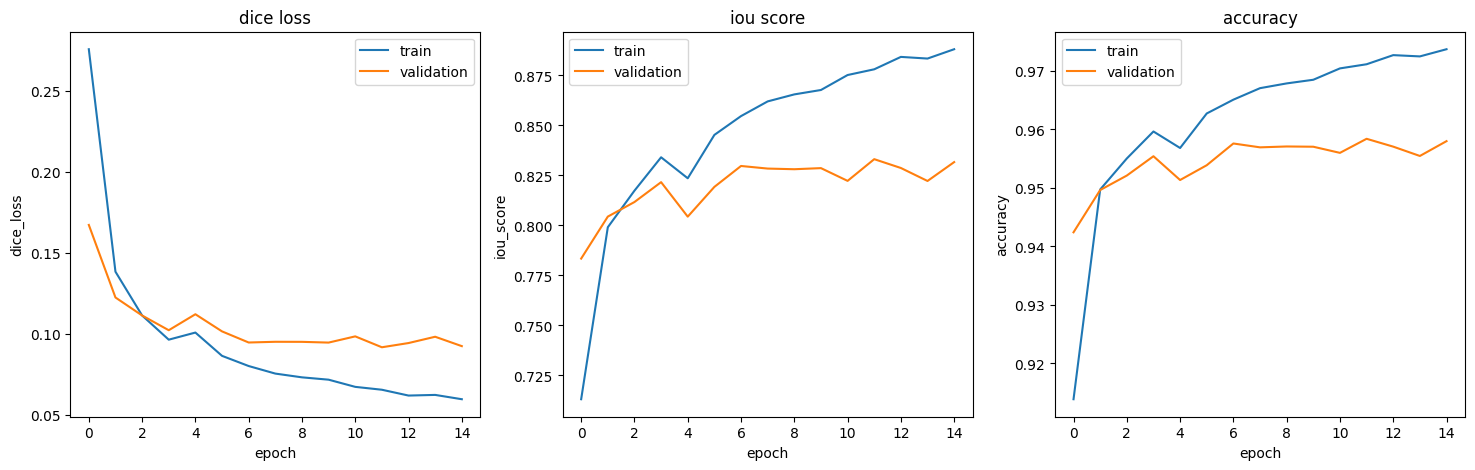

In [86]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 3, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(1, 3, 3)
line1, = ax3.plot(x_epoch_data,train_accuracy,label='train')
line2, = ax3.plot(x_epoch_data,valid_accuracy,label='validation') 
ax3.set_title("accuracy")
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend(loc='upper left')

plt.show()

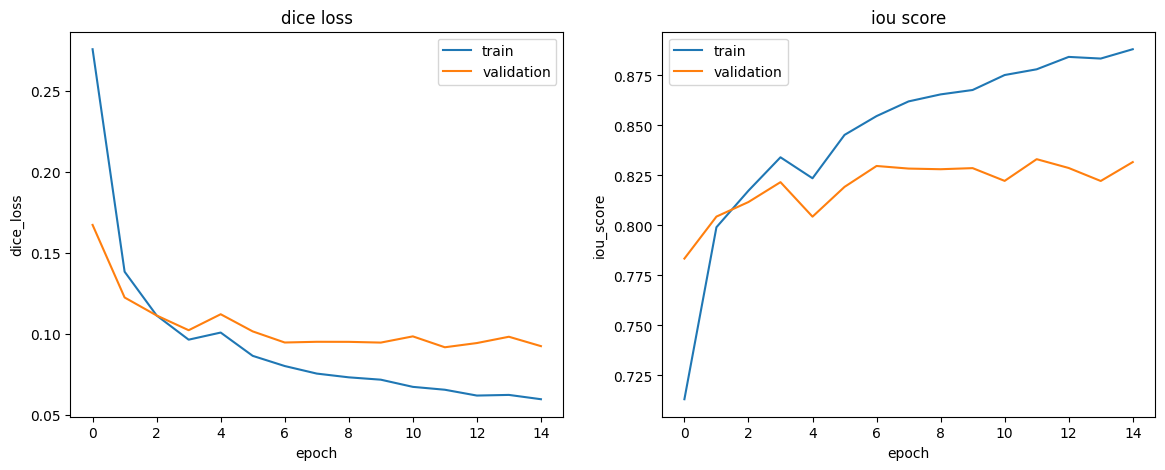

In [87]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

plt.show()

In [88]:
#best_model_unetpp = torch.load('./best_model_UnetPlusPlus_resnet50.pth')
best_model_unetpp = torch.load('./best_model_over10_UnetPlusPlus_resnet50.pth')

In [89]:
test_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=test_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing) 

In [90]:
test_dataloader = DataLoader(test_dataset)

In [91]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_unetpp,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 837/837 [00:31<00:00, 26.29it/s, dice_loss - 0.123, iou_score - 0.8009, accuracy - 0.96]   


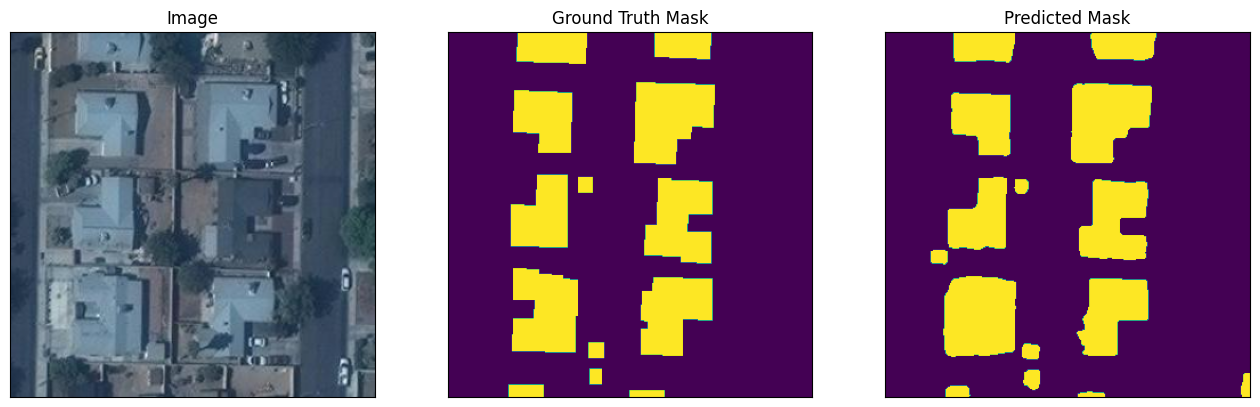

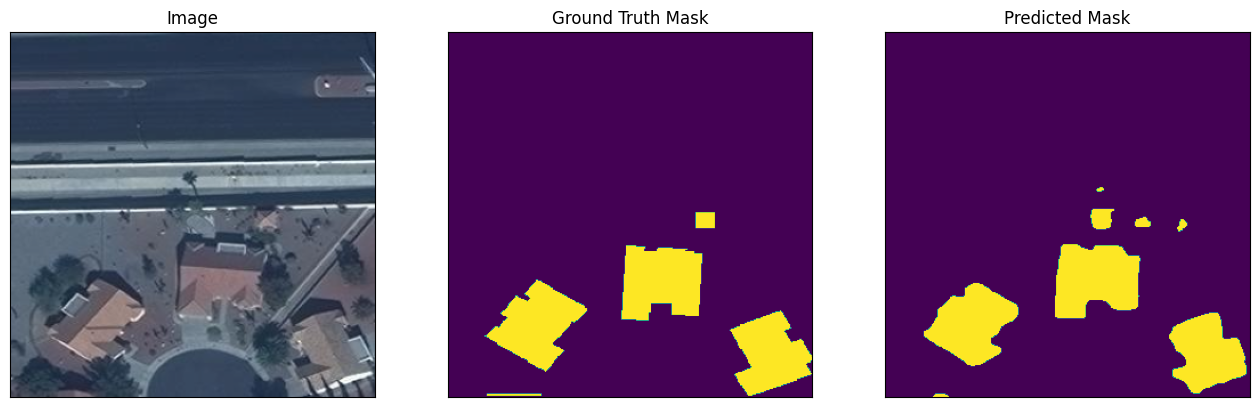

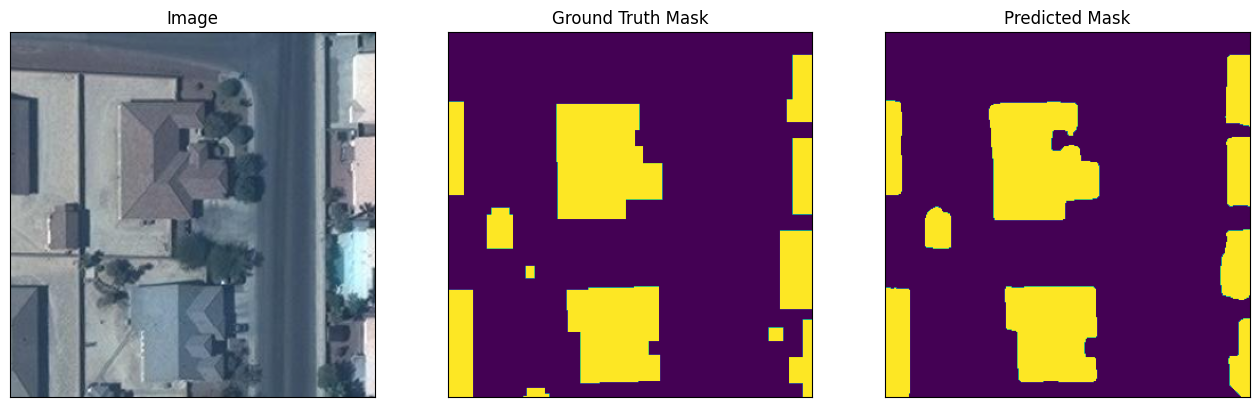

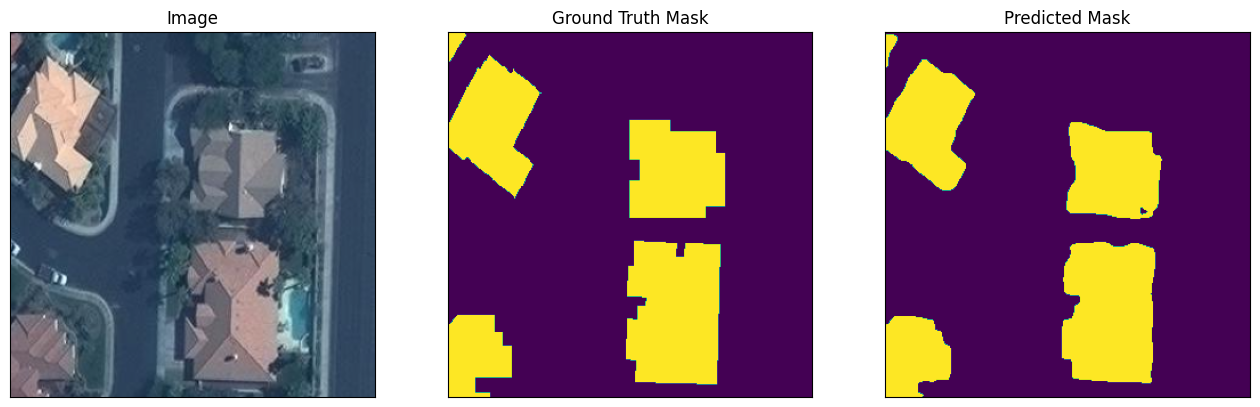

In [93]:
for i in range(4):
    n = i#np.random.choice(len(test_dataset))# вибрати конкретні рисунки для порівняння
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model_unetpp.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=denormalize(image), 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

---

### FPN

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch
import gc

del model_unet_pp, train_dataset, valid_dataset, test_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid'

model_fpn = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
basic_preprocessing = get_basic_preprocessing(preprocessing_fn)

train_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

valid_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=valid_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),smp.utils.metrics.Accuracy(threshold=0.5),]
optimizer = torch.optim.Adam([dict(params=model_fpn.parameters(), lr=0.0001),])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model_fpn, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model_fpn, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_iou_score = []
train_accuracy = []
valid_dice_loss = []
valid_iou_score = []
valid_accuracy = []

for i in range(EPOCHS):

    print(f'\nEpoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    train_accuracy.append(train_logs['accuracy'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    valid_accuracy.append(valid_logs['accuracy'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model_fpn, './best_model_FPN_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 3, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(1, 3, 3)
line1, = ax3.plot(x_epoch_data,train_accuracy,label='train')
line2, = ax3.plot(x_epoch_data,valid_accuracy,label='validation') 
ax3.set_title("accuracy")
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend(loc='upper left')

plt.show()

In [ ]:
best_model_fpn = torch.load('./best_model_FPN_resnet50.pth')

In [ ]:
test_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=test_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing) 

In [ ]:
test_dataloader = DataLoader(test_dataset)

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_fpn,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

---

In [ ]:
temp_metrics=[[0,0,0]]

In [ ]:
def k_means_predict_mask(img_data, gt_mask, num_clusters):
    k_means_img, k_means_labels = k_means(img_data, num_clusters)
    cluster_masks = create_cluster_masks(k_means_labels, num_clusters=num_clusters)
    if gt_mask.ndim == 3 and gt_mask.shape[0] == 1:
        gt_mask = np.squeeze(gt_mask, axis=0)
    #gt_mask = rows_to_segmentation(img_data, c_df)

    best_iou = 0
    best_dice_loss = 1
    chosen_acc = 0
    best_mask=cluster_masks[0]
    
    for mask in cluster_masks:
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)
        temp_metrics.append([curr_iou, curr_dice_loss, curr_acc])


        if curr_iou > best_iou:
            best_iou = curr_iou
            best_dice_loss = curr_dice_loss
            chosen_acc = curr_acc
            best_mask=mask

        #curr_id += 1
    #print(f"    best_iou: {best_iou}, best_dice_loss: {best_dice_loss}, chosen_acc: {chosen_acc}")
    temp_metrics.append([best_iou, best_dice_loss, chosen_acc])
    return best_mask

In [ ]:
def fuzzy_c_means(image, num_clusters=3, fuzziness=2):
    #image = img_as_float(image)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape((-1, 3))

    cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(pixels.T, c=num_clusters, m=fuzziness, error=0.005, maxiter=1000, init=None)
    cluster_membership = np.argmax(u_orig, axis=0)
    result_img = np.zeros_like(pixels)
    for i, pix in enumerate(u_orig.T):
        result_img[i] = cntr[np.argmax(pix)]

    fuzzy_image = result_img.reshape(image.shape).astype(np.uint8)

    cluster_membership = np.argmax(u_orig, axis=0).reshape(image.shape[:2])
    
    return fuzzy_image, cluster_membership

In [ ]:
def fuzzy_c_means_predict_mask(img_data, gt_mask, num_clusters):
    fuzzy_c_means_img, fuzzy_labels = fuzzy_c_means(img_data, num_clusters)
    cluster_masks = create_cluster_masks(fuzzy_labels, num_clusters=num_clusters)
    if gt_mask.ndim == 3 and gt_mask.shape[0] == 1:
        gt_mask = np.squeeze(gt_mask, axis=0)
    #gt_mask = rows_to_segmentation(img_data, c_df)

    best_iou = 0
    best_dice_loss = 1
    chosen_acc = 0
    best_mask=cluster_masks[0]
    
    for mask in cluster_masks:
        curr_iou = iou(gt_mask, mask)
        curr_dice_loss = dice_loss(gt_mask, mask)
        curr_acc = accuracy(gt_mask, mask)
        temp_metrics.append([curr_iou, curr_dice_loss, curr_acc])


        if curr_iou > best_iou:
            best_iou = curr_iou
            best_dice_loss = curr_dice_loss
            chosen_acc = curr_acc
            best_mask=mask

        #curr_id += 1
    #print(f"    best_iou: {best_iou}, best_dice_loss: {best_dice_loss}, chosen_acc: {chosen_acc}")
    temp_metrics.append([best_iou, best_dice_loss, chosen_acc])
    return best_mask

In [ ]:
def morphacwe_predict_mask(img_data, gt_mask):
    morph_acwe_mask = morph_acwe(img_data)
    morph_acwe_mask = morph_acwe_mask.astype(bool)
    if gt_mask.ndim == 3 and gt_mask.shape[0] == 1:
        gt_mask = np.squeeze(gt_mask, axis=0)
    #print(morph_acwe_mask)
    neg_morph_acwe_mask = np.invert(morph_acwe_mask)
    #print(neg_morph_acwe_mask)
    acwe_iou = iou(gt_mask, morph_acwe_mask)
    neg_acwe_iou = iou(gt_mask, neg_morph_acwe_mask)
    if neg_acwe_iou > acwe_iou:
        acwe_img = neg_morph_acwe_mask
        curr_iou = neg_acwe_iou
    else:
        acwe_img = morph_acwe_mask
        curr_iou = acwe_iou
    
    curr_dice_loss = dice_loss(gt_mask, acwe_img)
    curr_acc = accuracy(gt_mask, acwe_img)

    temp_metrics.append([curr_iou, curr_dice_loss, curr_acc])
    return acwe_img
    

In [ ]:
for i in range(4):
    #n = i#np.random.choice(len(test_dataset))# вибрати конкретні рисунки для порівняння
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask_fpn = best_model_fpn.predict(x_tensor)
    pr_mask_fpn = (pr_mask_fpn.squeeze().cpu().numpy().round())
    
    pr_mask_unet = best_model_unet.predict(x_tensor)
    pr_mask_unet = (pr_mask_unet.squeeze().cpu().numpy().round())

    pr_mask_unetpp = best_model_unetpp.predict(x_tensor)
    pr_mask_unetpp = (pr_mask_unetpp.squeeze().cpu().numpy().round())
    visualize(
        original_image=denormalize(image), 
        ground_truth=gt_mask, 
        fpn=pr_mask_fpn,
        unet=pr_mask_unet,
        unet_plus_plus=pr_mask_unetpp,
        best_kmeans = k_means_predict_mask(denormalize(image), gt_mask, 3),
        best_fuzzy_c_means = fuzzy_c_means_predict_mask(denormalize(image), gt_mask, 3),
        best_morphacwe = morphacwe_predict_mask(denormalize(image), gt_mask)
        
    )
    temp_metrics.append([0,0,0])

### U-Net

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch
import gc

del model_fpn, train_dataset, valid_dataset, test_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation

# create segmentation model with pretrained encoder
model_unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
basic_preprocessing = get_basic_preprocessing(preprocessing_fn)

train_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

valid_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=valid_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

In [ ]:
image, mask = train_dataset[0]
visualize(image=image.transpose(1, 2, 0), mask=mask.squeeze())

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),smp.utils.metrics.Accuracy(threshold=0.5),]
optimizer = torch.optim.Adam([dict(params=model_unet.parameters(), lr=0.0001),])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model_unet, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model_unet, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_iou_score = []
train_accuracy = []
valid_dice_loss = []
valid_iou_score = []
valid_accuracy = []

for i in range(EPOCHS):

    print(f'\nEpoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    train_accuracy.append(train_logs['accuracy'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    valid_accuracy.append(valid_logs['accuracy'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model_unet, './best_model_Unet_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 3, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(1, 3, 3)
line1, = ax3.plot(x_epoch_data,train_accuracy,label='train')
line2, = ax3.plot(x_epoch_data,valid_accuracy,label='validation') 
ax3.set_title("accuracy")
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend(loc='upper left')

plt.show()

In [ ]:
best_model_unet = torch.load('./best_model_Unet_resnet50.pth')

In [ ]:
test_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=test_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing) 

In [ ]:
test_dataloader = DataLoader(test_dataset)

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_unet,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

---

### U-Net Modifications

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch
import gc

del model_c_unet_plus_plus, train_dataset, valid_dataset, test_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [37]:
from segmentation_models_pytorch.base import modules as md

In [ ]:
class DilationCenterBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True, dilation_rates=[1, 2, 4, 8]):
        super().__init__()
        self.dilated_convs = nn.ModuleList([
            md.Conv2dReLU(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=dilation,
                dilation=dilation,
                use_batchnorm=use_batchnorm,
            ) for dilation in dilation_rates
        ])

    def forward(self, x):
        outputs = [conv(x) for conv in self.dilated_convs]
        return torch.cat(outputs, dim=1)  # Concatenating along the channel dimension

In [ ]:
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder
from segmentation_models_pytorch.decoders.unet.model import Unet


In [ ]:
class CustomUnetDecoder(UnetDecoder):
    def __init__(self, encoder_channels, decoder_channels, n_blocks, use_batchnorm, center, attention_type):
        super().__init__(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            n_blocks=n_blocks,
            use_batchnorm=use_batchnorm,
            center=center,
            attention_type=attention_type
        )
        if center:
            in_channels = encoder_channels[0]  
            self.center = DilationCenterBlock(in_channels, decoder_channels[0], use_batchnorm=use_batchnorm)

In [ ]:
class CustomUnet(Unet):
    def __init__(self, encoder_name, encoder_weights, encoder_depth, decoder_channels, decoder_use_batchnorm, decoder_attention_type, classes, activation):
        super().__init__(
            encoder_name=encoder_name,
            encoder_depth=encoder_depth,
            encoder_weights=encoder_weights,
            decoder_channels=decoder_channels,
            decoder_use_batchnorm=decoder_use_batchnorm,
            decoder_attention_type=decoder_attention_type,
            classes=classes,
            activation=activation
        )
        self.decoder = CustomUnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type
        )

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation

# create segmentation model with pretrained encoder
model_c_unet = CustomUnet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    encoder_depth=5,
    decoder_channels=[256, 128, 64, 32, 16],
    decoder_use_batchnorm=True,
    decoder_attention_type=None,
    classes=len(CLASSES),
    activation=ACTIVATION
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
basic_preprocessing = get_basic_preprocessing(preprocessing_fn)

train_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

valid_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=valid_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

In [ ]:
image, mask = train_dataset[0]
visualize(image=image.transpose(1, 2, 0), mask=mask.squeeze())

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),smp.utils.metrics.Accuracy(threshold=0.5),]
optimizer = torch.optim.Adam([dict(params=model_c_unet.parameters(), lr=0.0001),])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model_c_unet, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model_c_unet, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_iou_score = []
train_accuracy = []
valid_dice_loss = []
valid_iou_score = []
valid_accuracy = []

for i in range(EPOCHS):

    print(f'\nEpoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    train_accuracy.append(train_logs['accuracy'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    valid_accuracy.append(valid_logs['accuracy'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model_c_unet, './best_model_custom_Unet_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 3, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(1, 3, 3)
line1, = ax3.plot(x_epoch_data,train_accuracy,label='train')
line2, = ax3.plot(x_epoch_data,valid_accuracy,label='validation') 
ax3.set_title("accuracy")
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend(loc='upper left')

plt.show()

In [ ]:
best_model_c_unet = torch.load('./best_model_custom_Unet_resnet50.pth')

In [ ]:
test_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=test_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing) 

In [ ]:
test_dataloader = DataLoader(test_dataset)

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_c_unet,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

In [ ]:
for i in range(4):
    #n = i#np.random.choice(len(test_dataset))# вибрати конкретні рисунки для порівняння
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask_c_unet = best_model_c_unet.predict(x_tensor)
    pr_mask_c_unet = (pr_mask_c_unet.squeeze().cpu().numpy().round())

    visualize(
        original_image=denormalize(image), 
        ground_truth=gt_mask, 
        modified_unet=pr_mask_c_unet        
    )

---
### Modified U-Net++

In [35]:
from segmentation_models_pytorch.decoders.unetplusplus.decoder import UnetPlusPlusDecoder
from segmentation_models_pytorch.decoders.unetplusplus.model import UnetPlusPlus


In [36]:
class DilatedCenterBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True, dilation_rates=[1, 2, 4, 8]):
        super().__init__()
        self.dilated_convs = nn.ModuleList([
            md.Conv2dReLU(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=dilation,
                dilation=dilation,
                use_batchnorm=use_batchnorm,
            ) for dilation in dilation_rates
        ])

    def forward(self, x):
        outputs = [conv(x) for conv in self.dilated_convs]
        return torch.cat(outputs, dim=1)  # Concatenating along the channel dimension


In [38]:
class CustomUnetPlusPlusDecoder(UnetPlusPlusDecoder):
    def __init__(self, encoder_channels, decoder_channels, n_blocks, use_batchnorm, center, attention_type):
        super().__init__(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            n_blocks=n_blocks,
            use_batchnorm=use_batchnorm,
            center=center,
            attention_type=attention_type
        )
        # Assuming modification is required at the center block
        if center:
            self.center = DilatedCenterBlock(encoder_channels[-1], decoder_channels[-1], use_batchnorm)


In [39]:
class CustomUnetPlusPlus(UnetPlusPlus):
    def __init__(self, encoder_name, encoder_depth, encoder_weights, decoder_channels, decoder_use_batchnorm, decoder_attention_type, classes, in_channels, activation):
        # superclass initialization
        super().__init__(
            encoder_name=encoder_name,
            encoder_depth=encoder_depth,
            encoder_weights=encoder_weights,
            decoder_channels=decoder_channels,
            decoder_use_batchnorm=decoder_use_batchnorm,
            decoder_attention_type=decoder_attention_type,
            in_channels=in_channels,
            classes=classes,
            activation=activation
        )
        # all configurations are set as attributes
        self.encoder_name = encoder_name
        self.decoder_channels = decoder_channels
        self.decoder_use_batchnorm = decoder_use_batchnorm
        self.decoder_attention_type = decoder_attention_type
        
        # custom decoder
        self.decoder = CustomUnetPlusPlusDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type
        )

In [40]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation

# create segmentation model with pretrained encoder
model_c_unet_plus_plus = CustomUnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    encoder_depth=5,
    decoder_channels=[256, 128, 64, 32, 16],
    decoder_use_batchnorm=True,
    decoder_attention_type=None,
    classes=len(CLASSES),
    in_channels=3,
    activation=ACTIVATION
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s] 


In [41]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [42]:
import torch
import gc

del model_c_unet, train_dataset, valid_dataset, test_dataset
gc.collect()
torch.cuda.empty_cache()


NameError: name 'model_c_unet' is not defined

In [43]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [44]:
basic_preprocessing = get_basic_preprocessing(preprocessing_fn)

train_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

valid_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=valid_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

In [45]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)

In [46]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),smp.utils.metrics.Accuracy(threshold=0.5),]
optimizer = torch.optim.Adam([dict(params=model_c_unet_plus_plus.parameters(), lr=0.0001),])

In [47]:
train_epoch = smp.utils.train.TrainEpoch(
    model_c_unet_plus_plus, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model_c_unet_plus_plus, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [48]:
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_iou_score = []
train_accuracy = []
valid_dice_loss = []
valid_iou_score = []
valid_accuracy = []

for i in range(EPOCHS):

    print(f'\nEpoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    train_accuracy.append(train_logs['accuracy'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    valid_accuracy.append(valid_logs['accuracy'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model_c_unet_plus_plus, './best_model_custom_Unet_Plus_Plus_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 52/52 [00:13<00:00,  3.99it/s, dice_loss - 0.1737, iou_score - 0.7826, accuracy - 0.9417]
Model saved!

Epoch: 2
valid: 100%|██████████| 52/52 [00:12<00:00,  4.01it/s, dice_loss - 0.1259, iou_score - 0.8029, accuracy - 0.9506]
Model saved!

Epoch: 3
valid: 100%|██████████| 52/52 [00:13<00:00,  3.99it/s, dice_loss - 0.1183, iou_score - 0.8029, accuracy - 0.9486]
Model saved!

Epoch: 4
valid: 100%|██████████| 52/52 [00:13<00:00,  3.99it/s, dice_loss - 0.1132, iou_score - 0.8042, accuracy - 0.9498]
Model saved!

Epoch: 5
valid: 100%|██████████| 52/52 [00:12<00:00,  4.01it/s, dice_loss - 0.1049, iou_score - 0.8155, accuracy - 0.9521]
Model saved!

Epoch: 6
valid: 100%|██████████| 52/52 [00:13<00:00,  3.97it/s, dice_loss - 0.09956, iou_score - 0.8228, accuracy - 0.9552]
Model saved!

Epoch: 7
valid: 100%|██████████| 52/52 [00:13<00:00,  3.98it/s, dice_loss - 0.09967, iou_score - 0.8219, accuracy - 0.9552]

Epoch: 8
valid: 100%|██████████| 52/52 [00:13<00:00

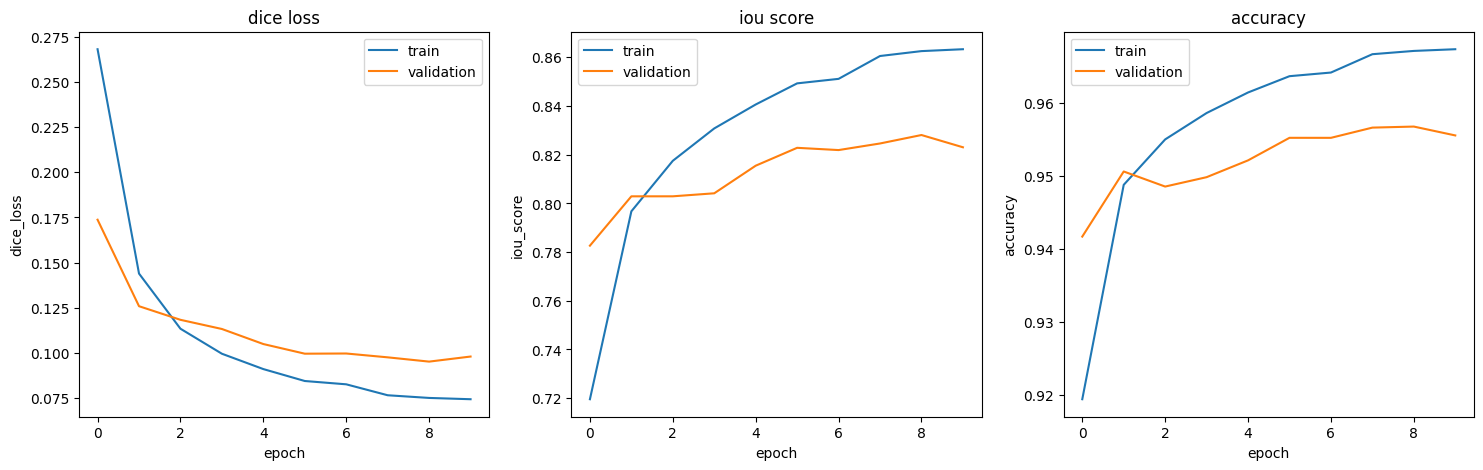

In [49]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 3, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(1, 3, 3)
line1, = ax3.plot(x_epoch_data,train_accuracy,label='train')
line2, = ax3.plot(x_epoch_data,valid_accuracy,label='validation') 
ax3.set_title("accuracy")
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend(loc='upper left')

plt.show()

In [50]:
best_model_c_unet_plus_plus = torch.load('./best_model_custom_Unet_Plus_Plus_resnet50.pth')

In [51]:
test_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=test_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing) 

In [52]:
test_dataloader = DataLoader(test_dataset)

In [53]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_c_unet_plus_plus,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 837/837 [00:37<00:00, 22.23it/s, dice_loss - 0.1271, iou_score - 0.7981, accuracy - 0.9588]


In [54]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_c_unet_plus_plus,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 837/837 [00:31<00:00, 26.90it/s, dice_loss - 0.1271, iou_score - 0.7981, accuracy - 0.9588]


In [ ]:
for i in range(4):
    #n = i#np.random.choice(len(test_dataset))# вибрати конкретні рисунки для порівняння
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask_c_unet_pp = best_model_c_unet_plus_plus.predict(x_tensor)
    pr_mask_c_unet_pp = (pr_mask_c_unet_pp.squeeze().cpu().numpy().round())

    visualize(
        original_image=denormalize(image), 
        ground_truth=gt_mask, 
        modified_unet_plus_plus=pr_mask_c_unet_pp
    )

---

----

### More epochs test

In [56]:
EPOCHS = 15
BATCH_SIZE = 16

In [57]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    950 MiB |  11593 MiB | 253737 GiB | 253736 GiB |
|       from large pool |    843 MiB |  11527 MiB | 253457 GiB | 253456 GiB |
|       from small pool |    106 MiB |    111 MiB |    279 GiB |    279 GiB |
|---------------------------------------------------------------------------|
| Active memory         |    950 MiB |  11593 MiB | 253737 GiB | 253736 GiB |
|       from large pool |    843 MiB |  11527 MiB | 253457 GiB |

In [58]:
import torch
import gc

del model_c_unet_plus_plus, train_dataset, valid_dataset, test_dataset
gc.collect()
torch.cuda.empty_cache()


In [59]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    950 MiB |  11593 MiB | 253737 GiB | 253736 GiB |
|       from large pool |    843 MiB |  11527 MiB | 253457 GiB | 253456 GiB |
|       from small pool |    106 MiB |    111 MiB |    279 GiB |    279 GiB |
|---------------------------------------------------------------------------|
| Active memory         |    950 MiB |  11593 MiB | 253737 GiB | 253736 GiB |
|       from large pool |    843 MiB |  11527 MiB | 253457 GiB |

In [60]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation

# create segmentation model with pretrained encoder
model_c_unet_plus_plus = CustomUnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    encoder_depth=5,
    decoder_channels=[256, 128, 64, 32, 16],
    decoder_use_batchnorm=True,
    decoder_attention_type=None,
    classes=len(CLASSES),
    in_channels=3,
    activation=ACTIVATION
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [61]:
basic_preprocessing = get_basic_preprocessing(preprocessing_fn)

train_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

valid_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=valid_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing)

In [62]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)

In [63]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),smp.utils.metrics.Accuracy(threshold=0.5),]
optimizer = torch.optim.Adam([dict(params=model_c_unet_plus_plus.parameters(), lr=0.0001),])

In [64]:
train_epoch = smp.utils.train.TrainEpoch(
    model_c_unet_plus_plus, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model_c_unet_plus_plus, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [65]:
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_iou_score = []
train_accuracy = []
valid_dice_loss = []
valid_iou_score = []
valid_accuracy = []

for i in range(EPOCHS):

    print(f'\nEpoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    train_accuracy.append(train_logs['accuracy'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    valid_accuracy.append(valid_logs['accuracy'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model_c_unet_plus_plus, './best_model_custom_Unet_Plus_Plus_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 52/52 [00:12<00:00,  4.03it/s, dice_loss - 0.1392, iou_score - 0.7841, accuracy - 0.9437]
Model saved!

Epoch: 2
valid: 100%|██████████| 52/52 [00:12<00:00,  4.05it/s, dice_loss - 0.1152, iou_score - 0.8044, accuracy - 0.9491]
Model saved!

Epoch: 3
valid: 100%|██████████| 52/52 [00:12<00:00,  4.04it/s, dice_loss - 0.1086, iou_score - 0.8101, accuracy - 0.9515]
Model saved!

Epoch: 4
valid: 100%|██████████| 52/52 [00:12<00:00,  4.04it/s, dice_loss - 0.106, iou_score - 0.8125, accuracy - 0.9525] 
Model saved!

Epoch: 5
valid: 100%|██████████| 52/52 [00:12<00:00,  4.05it/s, dice_loss - 0.1139, iou_score - 0.7982, accuracy - 0.9473]

Epoch: 6
valid: 100%|██████████| 52/52 [00:12<00:00,  4.04it/s, dice_loss - 0.09907, iou_score - 0.8221, accuracy - 0.9559]
Model saved!

Epoch: 7
valid: 100%|██████████| 52/52 [00:12<00:00,  4.03it/s, dice_loss - 0.09808, iou_score - 0.8235, accuracy - 0.9559]
Model saved!

Epoch: 8
valid: 100%|██████████| 52/52 [00:12<00:00

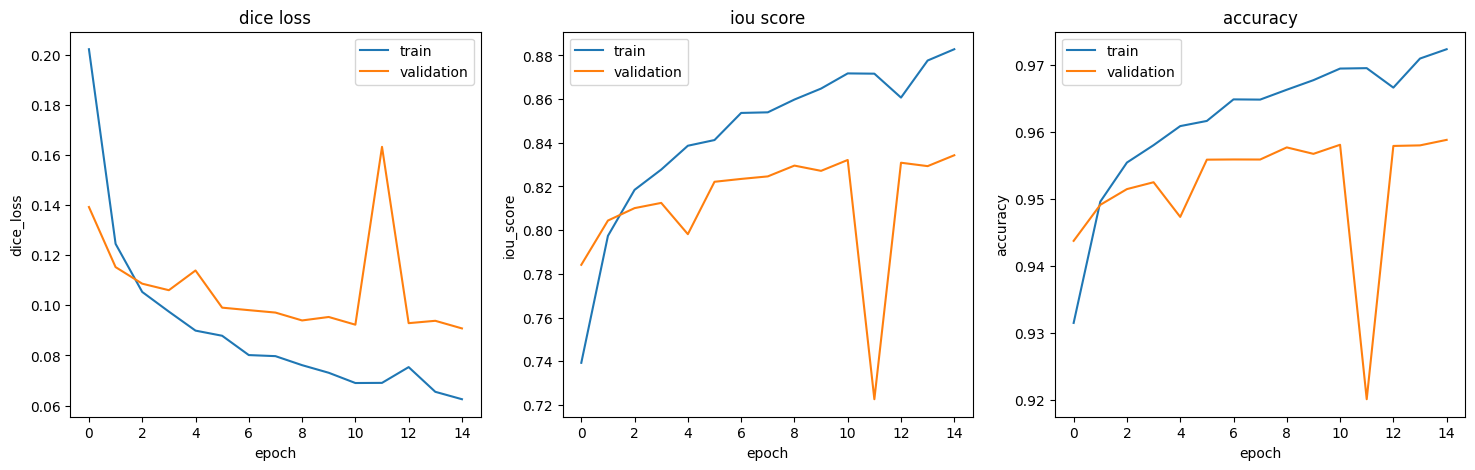

In [66]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 3, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

ax3 = fig.add_subplot(1, 3, 3)
line1, = ax3.plot(x_epoch_data,train_accuracy,label='train')
line2, = ax3.plot(x_epoch_data,valid_accuracy,label='validation') 
ax3.set_title("accuracy")
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend(loc='upper left')

plt.show()

In [71]:
best_model_c_unet_plus_plus = torch.load('./best_model_custom_Unet_Plus_Plus_resnet50.pth')

In [72]:
test_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=test_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           preprocessing=basic_preprocessing) 

In [73]:
test_dataloader = DataLoader(test_dataset)

In [74]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_c_unet_plus_plus,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 837/837 [00:30<00:00, 27.10it/s, dice_loss - 0.1218, iou_score - 0.8029, accuracy - 0.9603]


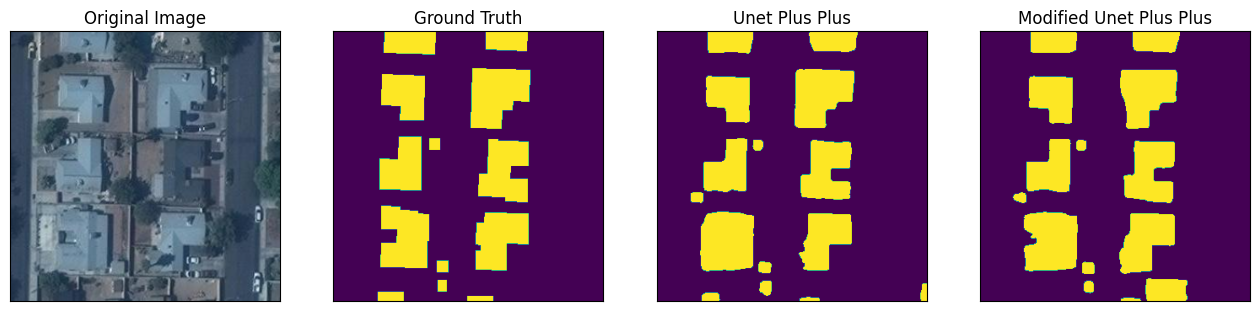

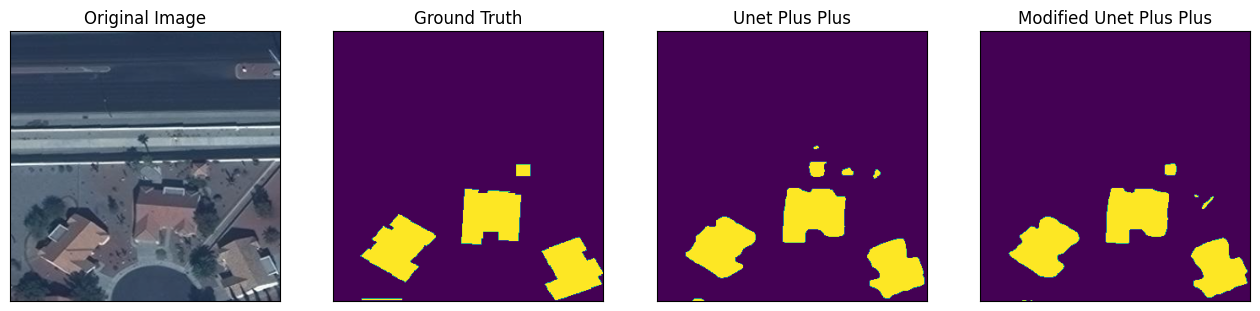

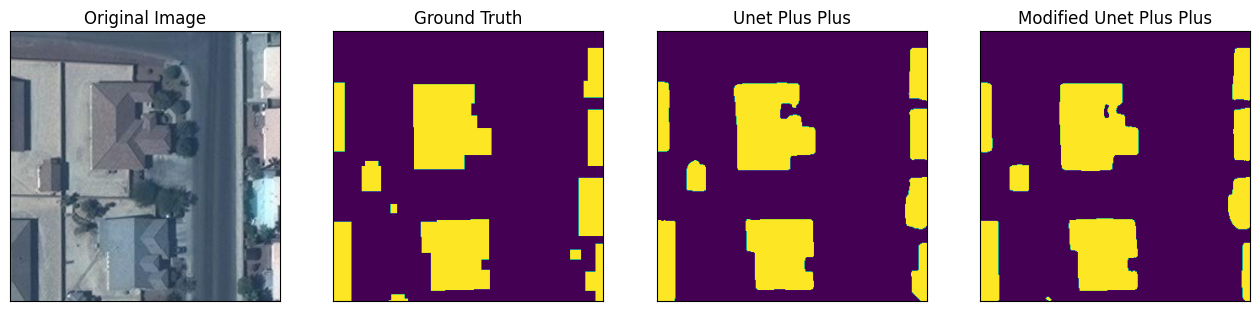

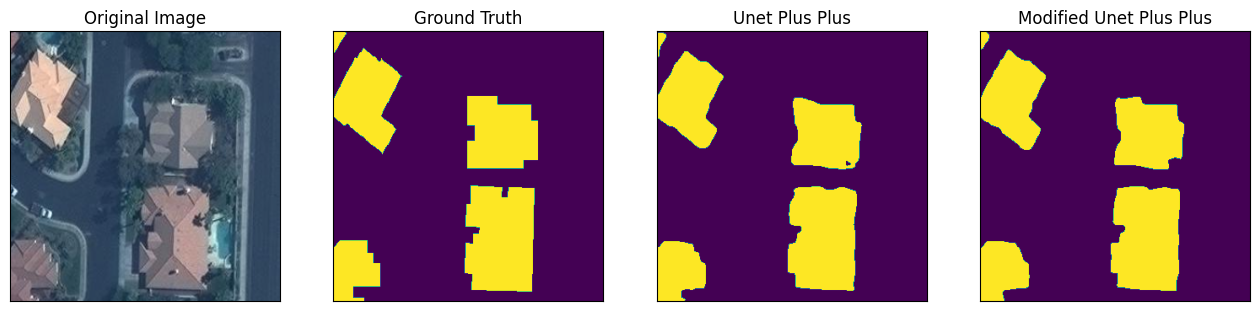

In [94]:
for i in range(4):
    #n = i#np.random.choice(len(test_dataset))# вибрати конкретні рисунки для порівняння
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    
    pr_mask_unet_pp = best_model_unetpp.predict(x_tensor)
    pr_mask_unet_pp = (pr_mask_unet_pp.squeeze().cpu().numpy().round())
    
    pr_mask_c_unet_pp = best_model_c_unet_plus_plus.predict(x_tensor)
    pr_mask_c_unet_pp = (pr_mask_c_unet_pp.squeeze().cpu().numpy().round())
    
    visualize(
        original_image=denormalize(image), 
        ground_truth=gt_mask, 
        unet_plus_plus=pr_mask_unet_pp,
        modified_unet_plus_plus=pr_mask_c_unet_pp
        
        
    )